<h1><center>Titanic Classification of Survivor</center></h1>

<img src='img/Titanic.jpg'>

## Contents

- EDA
- Preprocessing
- Feature select
- Modeling
- Submission

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import *
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import * # make confusion matrix

import xgboost
from sklearn.ensemble import RandomForestClassifier

from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")

---

## 1. EDA

### 1.1 Overall information

In [2]:
# check shape
print('train shape :', train.shape)
print('test shape :', test.shape)

train shape : (891, 12)
test shape : (418, 11)


#### comments :

- train : 총 891개 데이터, 12개 컬럼으로 구성 (y포함)
- test : 총 418개 데이터, 11개 컬럼으로 구성

In [3]:
# information
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [4]:
# check null
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

#### comments :

- Age 결측치 : 177개
- Cabin 결측치 : 687개
- Embarked 결측치 : 2개

In [5]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [6]:
# Unique
print('train unique 갯수')
for i in range(12):
    print('{} : {}개'.format(train.columns[i], len(set(train[train.columns[i]]))))

train unique 갯수
PassengerId : 891개
Survived : 2개
Pclass : 3개
Name : 891개
Sex : 2개
Age : 265개
SibSp : 7개
Parch : 7개
Ticket : 681개
Fare : 248개
Cabin : 148개
Embarked : 4개


#### commnets :

- PassengerId, Name는 고유값
- Pclass(3), Sex(2), SibSp(7), Parch(7), Embarked(2)는 카테고리형
- Ticket, Cabin은 카테고리같긴한데 너무 분류가 많음
- Age, Fare는 연속형
- Survived(y값)은 2개로 구성

### 1.2 Y data

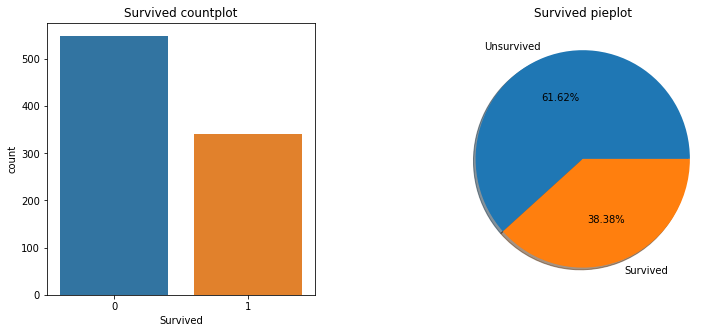

In [7]:
# y_data
plt.figure(figsize=(12, 5))
subplots_adjust(wspace = 0.5)


df = pd.DataFrame([len(train[train['Survived'] == 0])/len(train), 
                   len(train[train['Survived'] == 1])/len(train)], 
                   index=['Unsurvived', 'Survived'], columns=['x'])

# countplot
plt.subplot(1, 2, 1)
sns.countplot(x = 'Survived', data = train)
plt.title('Survived countplot')
labels = 'Unsurvived', 'Survived'

# pieplot
plt.subplot(1, 2, 2)
plt.pie(df, labels = labels, autopct='%1.2f%%', shadow = True, explode = (0.0, 0.0))
plt.title('Survived pieplot')

plt.show()

### 1.3 X & Y data

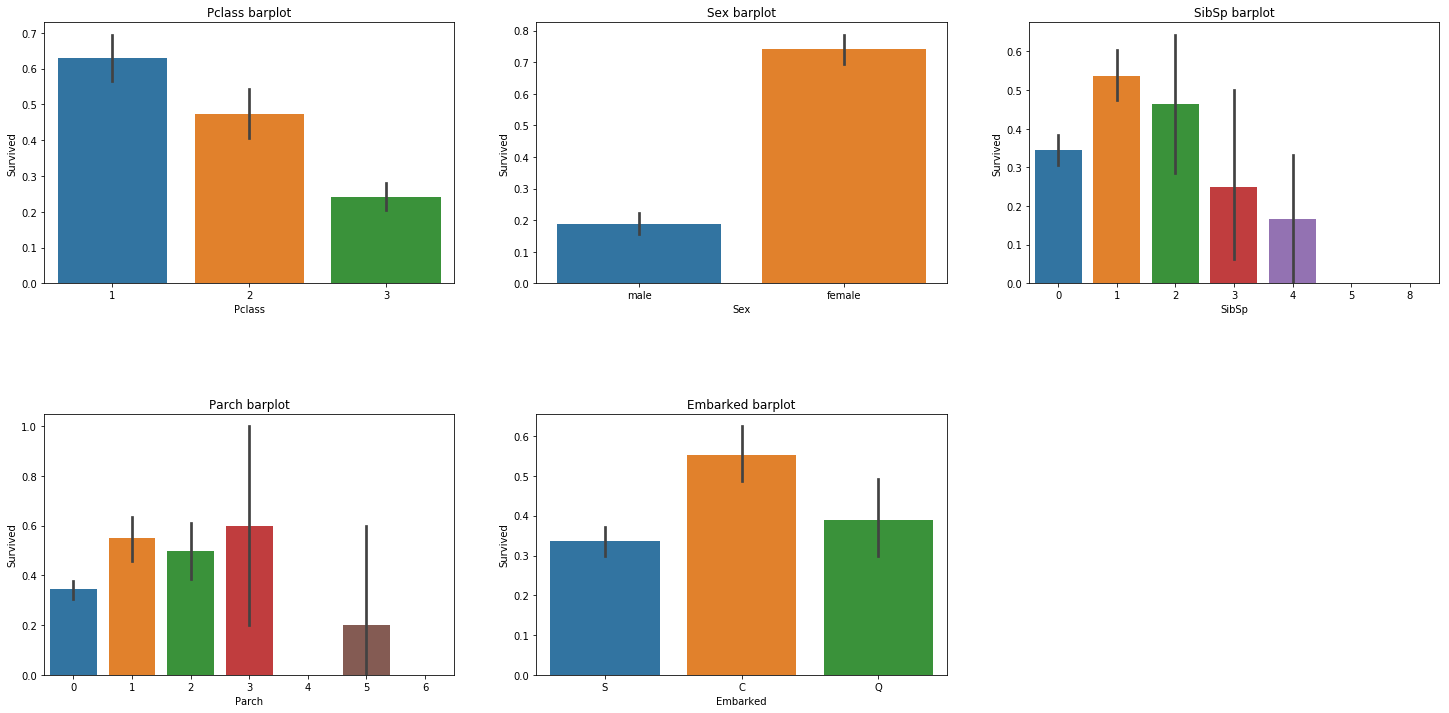

In [8]:
# category barplot
category = ['Pclass', 'Sex', 'SibSp', 'Parch', 'Embarked']

plt.figure(figsize=(25, 12))
subplots_adjust(hspace = 0.5)

for i in range(5):
    plt.subplot(2, 3, i+1)
    sns.barplot(x = train[category[i]], y = train['Survived'])
    plt.title('{} barplot'.format(train[category].columns[i]))

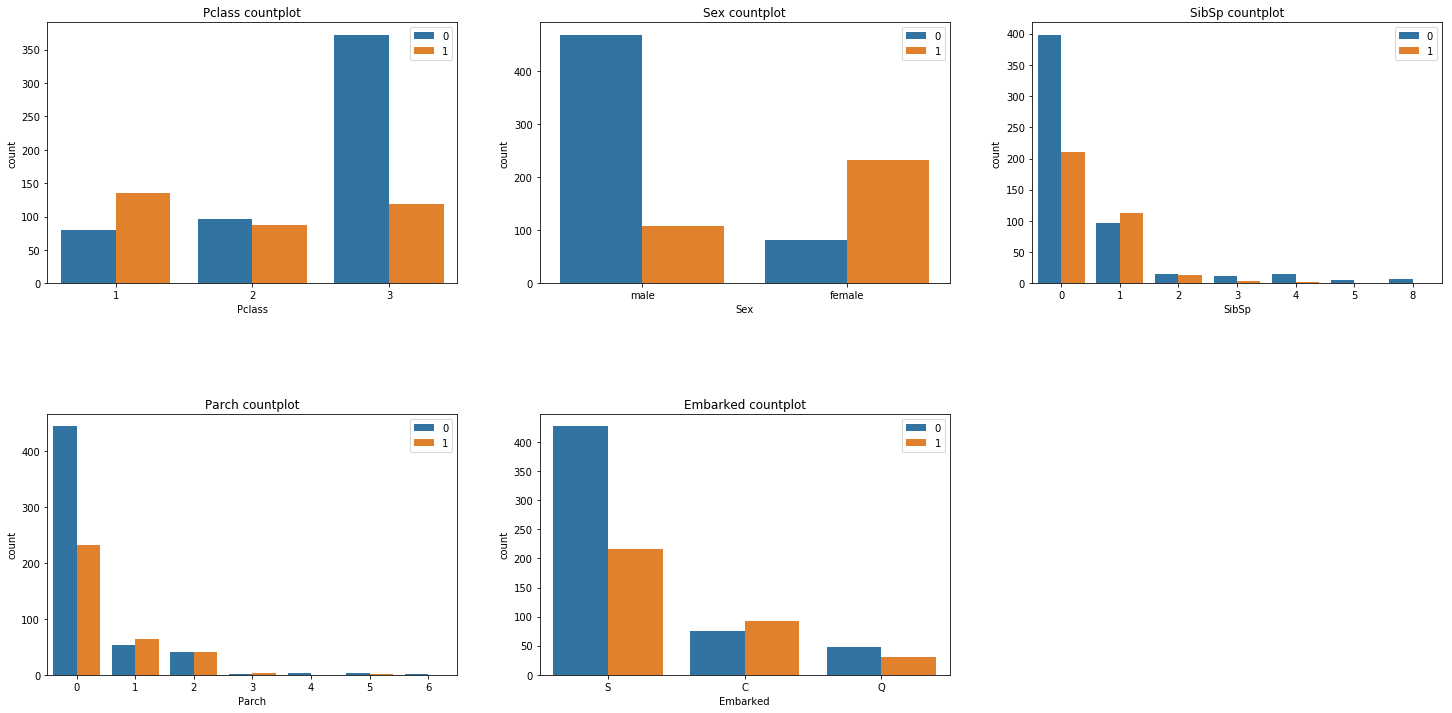

In [9]:
# category countplot
plt.figure(figsize=(25, 12))
subplots_adjust(hspace = 0.5)

for i in range(5):
    plt.subplot(2, 3, i+1)
    sns.countplot(x=train[category[i]], hue = 'Survived',  data = train)
    plt.legend(loc = 1)
    plt.title('{} countplot'.format(train[category].columns[i]))

#### Commnets :

- Pclass의 경우 클래스가 높을수록 생존률이 높은것으로 확인됨
- Sex의 경우 여성이 생존률이 월등히 높음
- SibSp의 경우 형재자매나 배우자의 수가 1명일 경우가 제일 생존률이 높음
- Parch는 1,2,3이 비슷함
- Embarked는 C구역에서 승선할 경우 생존률이 높음

In [10]:
# cabin
cabin = train.groupby("Cabin").size().reset_index(name='counts')
cabin = cabin.sort_values(by=['counts'], ascending=False)
cabin = cabin.reset_index(drop=True)
cabin.head(10)

,Cabin,counts
0,C23 C25 C27,4
1,G6,4
2,B96 B98,4
3,F2,3
4,C22 C26,3
5,E101,3
6,F33,3
7,D,3
8,C78,2
9,B57 B59 B63 B66,2


#### comments :

- 카테고리 갯수가 많고 그 수가 차이가 별로 없어서 분류에 적합한 컬럼인지 고민할 필요가 있음

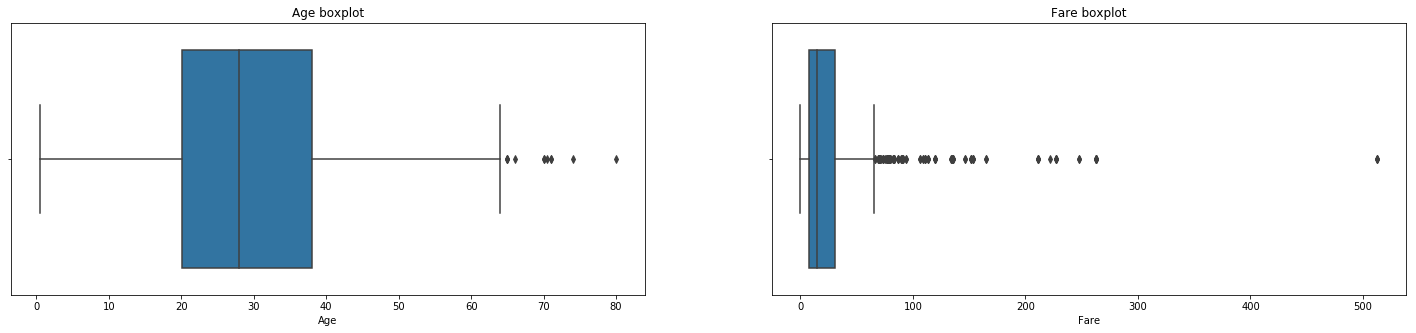

In [11]:
# continuos boxplot
continuos = ['Age', 'Fare']

plt.figure(figsize=(25, 5))

for i in range(2):
    plt.subplot(1, 2, i+1)
    sns.boxplot(x = train[continuos[i]])
    plt.title('{} boxplot'.format(train[continuos].columns[i]))

#### comments :

- age는 약 68세 이상부터 이상치를 나타냄
- fare는 편차가 많아 어느정도 이상치를 제거해야할것으로 보임

---

## 2. Preprocessing

### 2.1 Missing data

In [12]:
# age는 mean값으로 채우기
train['Age'] = train['Age'].fillna(train['Age'].mean())
test['Age'] = test['Age'].fillna(test['Age'].mean())

# embarked는 최빈값으로 채우기
embarked_mode = train['Embarked'].value_counts().index[0]
train['Embarked'] = train['Embarked'].fillna(embarked_mode)
embarked_mode = test['Embarked'].value_counts().index[0]
test['Embarked'] = test['Embarked'].fillna(embarked_mode)

/anaconda3/envs/practice/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/anaconda3/envs/practice/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


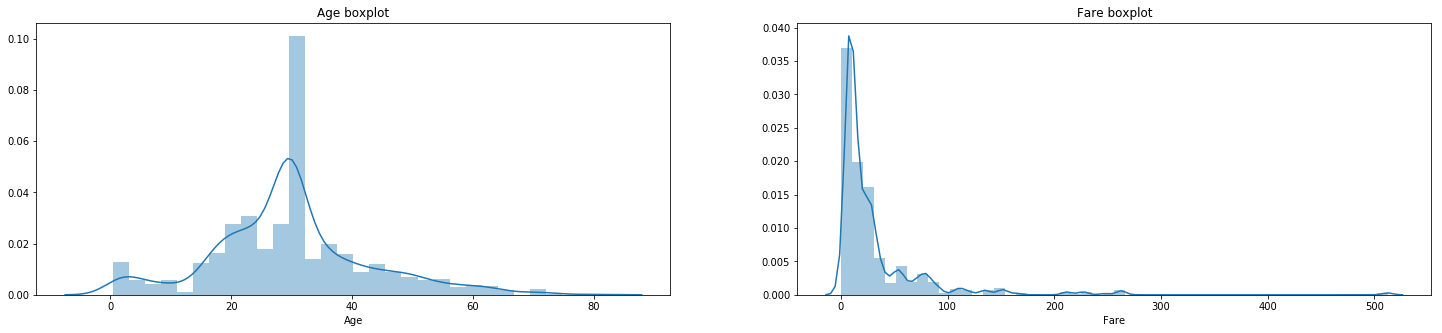

In [13]:
# continuos boxplot
continuos = ['Age', 'Fare']

plt.figure(figsize=(25, 5))

for i in range(2):
    plt.subplot(1, 2, i+1)
    sns.distplot(train[continuos[i]])
    plt.title('{} boxplot'.format(train[continuos].columns[i]))

### 2.2 Remove outlier

In [14]:
# fare가 200이상인 데이터 제거
train = train[train['Fare'] < 200].reset_index(drop=True)

# 제거한 데이터를 바탕으로 y설정
y = train['Survived']

### 2.3 Change object columns

In [15]:
# 분석을 위해 카테고리형 숫자로 만들기

# sex
train['Sex'] = train['Sex'].apply(lambda x: 0 if x == 'male' else 1)
test['Sex'] = test['Sex'].apply(lambda x: 0 if x == 'male' else 1)

# embarked
train.loc[train['Embarked']=='S', 'Embarked'] = 0
train.loc[train['Embarked']=='C', 'Embarked'] = 1
train.loc[train['Embarked']=='Q', 'Embarked'] = 2

test.loc[test['Embarked']=='S', 'Embarked'] = 0
test.loc[test['Embarked']=='C', 'Embarked'] = 1
test.loc[test['Embarked']=='Q', 'Embarked'] = 2

---

## 3. Feature Select

### 3.1 Correlation

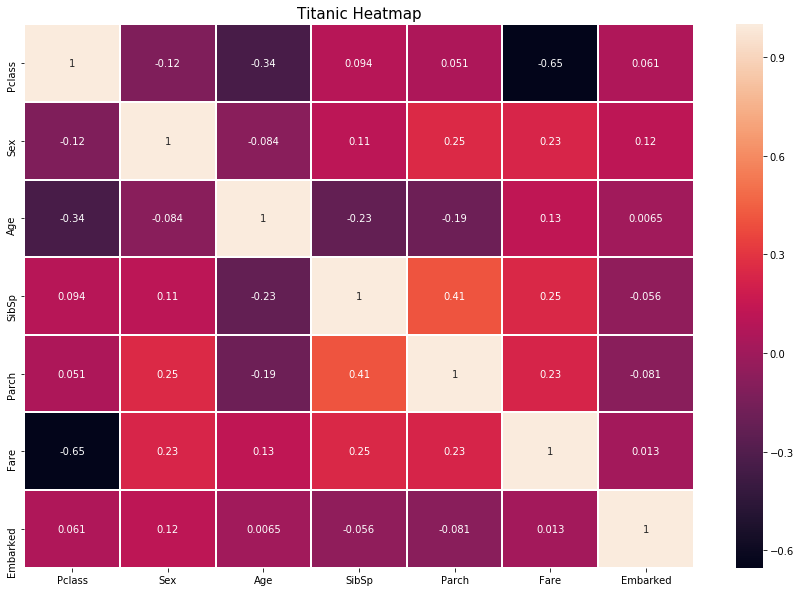

In [16]:
# correlation
correlation = train.drop(['PassengerId', 'Name', 'Ticket', 'Cabin', 'Survived'], axis = 1)

f, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(correlation.corr(), annot=True, linewidths=1)
plt.title('Titanic Heatmap', fontsize = 15)
plt.show()

#### commnets :

- 변수간의 상관관계가 낮음

### 3.2 VIF

In [17]:
train_vif = train.drop(['PassengerId', 'Name', 'Ticket', 'Cabin', 'Survived'], axis = 1)
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(train_vif.values, i) for i in range(train_vif.shape[1])]
vif["features"] = train_vif.columns
vif

,VIF Factor,features
0,4.302465,Pclass
1,1.706173,Sex
2,4.749047,Age
3,1.656886,SibSp
4,1.622567,Parch
5,2.516799,Fare
6,1.373279,Embarked


#### comments :

- 다중공선성은 없는것으로 확인됨

---

## 4. Modeling

### 4.1 One-Hot-Encoding

In [18]:
train = train.drop(['PassengerId', 'Name', 'Ticket', 'Cabin', 'Survived'], axis = 1)
submission_id = test['PassengerId']
test = test.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis = 1)

In [19]:
# one-hot encoding

# pclass
pclass = pd.get_dummies(train.Pclass)
pclass.rename(columns={1: 'pclass1', 2: 'pclass2', 3: 'pclass3'}, inplace=True)
train = pd.concat([train, pclass], axis=1)
train = train.drop(['Pclass'], axis=1)

# sibsp
sibsp = pd.get_dummies(train.SibSp)
sibsp.rename(columns={0: 'sibsp0', 1: 'sibsp1', 2: 'sibsp2', 3: 'sibsp3', 4: 'sibsp4', 5: 'sibsp5', 8:'sibsp8'}, inplace=True)
train = pd.concat([train, sibsp], axis=1)
train = train.drop(['SibSp'], axis=1)

# parch
parch = pd.get_dummies(train.Parch)
parch.rename(columns={0: 'parch0', 1: 'parch1', 2: 'parch2', 3: 'parch3', 4: 'parch4', 5: 'parch5', 6:'parch6'}, inplace=True)
train = pd.concat([train, parch], axis=1)
train = train.drop(['Parch'], axis=1)

# embarked
embarked = pd.get_dummies(train.Embarked)
embarked.rename(columns={0: 'embarked0', 1: 'embarked1', 2: 'embarked2'}, inplace=True)
train = pd.concat([train, embarked], axis=1)
train = train.drop(['Embarked'], axis=1)

In [20]:
# one-hot encoding

# pclass
pclass = pd.get_dummies(test.Pclass)
pclass.rename(columns={1: 'pclass1', 2: 'pclass2', 3: 'pclass3'}, inplace=True)
test = pd.concat([test, pclass], axis=1)
test = test.drop(['Pclass'], axis=1)

# sibsp
sibsp = pd.get_dummies(test.SibSp)
sibsp.rename(columns={0: 'sibsp0', 1: 'sibsp1', 2: 'sibsp2', 3: 'sibsp3', 4: 'sibsp4', 5: 'sibsp5', 8:'sibsp8'}, inplace=True)
test = pd.concat([test, sibsp], axis=1)
test = test.drop(['SibSp'], axis=1)

# parch
parch = pd.get_dummies(test.Parch)
parch.rename(columns={0: 'parch0', 1: 'parch1', 2: 'parch2', 3: 'parch3', 4: 'parch4', 5: 'parch5', 6:'parch6'}, inplace=True)
test = pd.concat([test, parch], axis=1)
test = test.drop(['Parch'], axis=1)

# embarked
embarked = pd.get_dummies(test.Embarked)
embarked.rename(columns={0: 'embarked0', 1: 'embarked1', 2: 'embarked2'}, inplace=True)
test = pd.concat([test, embarked], axis=1)
test = test.drop(['Embarked'], axis=1)

### 4.2 Modeling - Train split

In [21]:
# split data
X_train, X_test, y_train, y_test = train_test_split(train, y, test_size=0.2, random_state=42)

# DecisionTree
from sklearn import tree
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print('confusion matrix :\n\n', confusion_matrix(y_test, y_pred))
print('\n')
print('classification_report :\n\n', classification_report(y_test, y_pred, target_names=['Unsurvived','Survived']))

confusion matrix :

 [[83 19]
 [20 53]]


classification_report :

              precision    recall  f1-score   support

 Unsurvived       0.81      0.81      0.81       102
   Survived       0.74      0.73      0.73        73

avg / total       0.78      0.78      0.78       175



In [22]:
# RandomForest
clf = RandomForestClassifier(max_depth=5, random_state=0)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print('confusion matrix :\n\n', confusion_matrix(y_test, y_pred))
print('\n')
print('classification_report :\n\n', classification_report(y_test, y_pred, target_names=['Unsurvived','Survived']))

confusion matrix :

 [[85 17]
 [27 46]]


classification_report :

              precision    recall  f1-score   support

 Unsurvived       0.76      0.83      0.79       102
   Survived       0.73      0.63      0.68        73

avg / total       0.75      0.75      0.75       175



In [23]:
import warnings
warnings.filterwarnings('ignore')

clf = xgboost.XGBClassifier(n_estimators=1000, max_depth=3)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print('confusion matrix :\n\n', confusion_matrix(y_test, y_pred))
print('\n')
print('classification_report :\n\n', classification_report(y_test, y_pred, target_names=['Unsurvived','Survived']))

confusion matrix :

 [[89 13]
 [20 53]]


classification_report :

              precision    recall  f1-score   support

 Unsurvived       0.82      0.87      0.84       102
   Survived       0.80      0.73      0.76        73

avg / total       0.81      0.81      0.81       175



#### Cross Validation

In [24]:
scores = cross_val_score(clf, X_train, y_train, cv=10)
print(scores)

[0.78873239 0.82857143 0.87142857 0.82857143 0.87142857 0.85507246
 0.75362319 0.8115942  0.73913043 0.8115942 ]


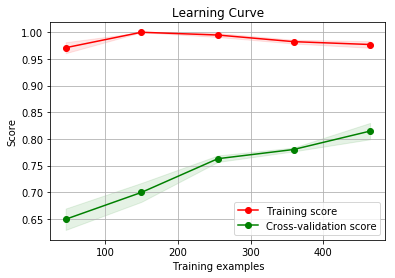

In [25]:
import scikitplot as skplt
skplt.estimators.plot_learning_curve(clf, X_train, y_train)
plt.show()

### 4.3 Modeling - Test data

In [26]:
test = test.drop([9], axis = 1)

clf = xgboost.XGBClassifier(n_estimators=1000, max_depth=3)
clf.fit(X_train, y_train)
y_pred = clf.predict(test)

In [27]:
submission = pd.DataFrame(columns = ['PassengerId', 'Survived'])
submission['PassengerId'] = submission_id
submission['Survived'] = y_pred

submission.to_csv('submission.csv', index = False)

### 4.4 GridSearch

In [28]:
param_grid = [
    {'n_estimators' : [10, 100, 1000], 'max_depth' : [2, 4, 6, 8]}]

model = xgboost.XGBClassifier()
grid_search = GridSearchCV(model, param_grid, cv = 5, return_train_score = True)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'n_estimators': [10, 100, 1000], 'max_depth': [2, 4, 6, 8]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [29]:
print(grid_search.best_params_)
print(grid_search.best_estimator_)

{'max_depth': 2, 'n_estimators': 100}
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=2, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)


In [30]:
clf = xgboost.XGBClassifier(n_estimators=100, max_depth=2)
clf.fit(X_train, y_train)
y_pred = clf.predict(test)

submission = pd.DataFrame(columns = ['PassengerId', 'Survived'])
submission['PassengerId'] = submission_id
submission['Survived'] = y_pred

submission.to_csv('submission2.csv', index = False)